# Connect to drive folder

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Install libraries

In [4]:
%%capture
!pip install osmnx polars pyshp geofeather
#!pip uninstall largestinteriorrectangle
!pip install largestinteriorrectangle 
#pyshp --> Python Shapefile Library (PyShp)

In [5]:
# Data management
import pandas as pd
import datetime
import numpy as np
import polars as pl
import zipfile, io
import os
import numpy as np
import re
import functools
import urllib
import shutil
import warnings
from collections import Counter
import progressbar
from time import sleep
import ast

warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

from shapely.geometry import Point, Polygon, MultiPoint
from operator import itemgetter
import folium
from shapely.ops import unary_union
from shapely import wkt
from pyproj import Geod


# Geospatial libraries
import osmnx as ox
import shapefile as shp
import geopandas as gpd
import geofeather
import pyproj
import cv2 as cv # --> per largestinteriorrectangle   
from folium.plugins import MarkerCluster

ox.config(log_console=True, use_cache=True)


# Plot
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
print(gpd.__version__)

0.13.2


# Dataset import and aggregation


In [45]:
mode_list = ['walk', 'bike']
name = {'new_building': ['nbw', 'nbb'], 'new_area_new_building': ['nanbw', 'nanbb'], 'renovation': ['rw', 'rb']}
dt_agg = {}

for Name, name2 in name.items():
  dt_agg[Name] = {'dataset_hub': None, 'dataset_acc': None}

  # Importiamo df con le info sugli hub 
  dfhw = pd.read_csv(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{Name}/{Name}_{mode_list[0]}.csv', index_col = 0)
  dfhw['Mode'] = 'walk'
  dfhb = pd.read_csv(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{Name}/{Name}_{mode_list[1]}.csv', index_col = 0)
  dfhb['Mode'] = 'bike'

  dfh = pd.concat([dfhw, dfhb], ignore_index = True)
  dfh.drop('index', axis = 1, inplace = True) 
  if Name == 'renovation': 
    geod = Geod(ellps="WGS84")
    dfh["poly_geom"] = gpd.GeoSeries.from_wkt(dfh["poly_geom"])   #poligono esterno
    dfh["centroid"] = gpd.GeoSeries.from_wkt(dfh["centroid"])   #centroide (Marker)
    # dfh["centroid"] = [x.centroid for x in dfh["centroid"]]   #centroide (Marker)
    
    # mp = [ast.literal_eval(pol.replace('<', '').replace('>', '')) for pol in dfh.multiPoly] 
    # dfh['multiPoly'] = mp
    # mp = [x.replace('MULTIPOLYGON (', 'POLYGON ').replace('$))', '') for x in dfh.multiPoly.to_list()] 
    # dfh['multiPoly'] = mp
    # dfh['multiPoly'] = gpd.GeoSeries.from_wkt(dfh['multiPoly'])
  else: 
    dfh["final_geometry_rectangular"] = gpd.GeoSeries.from_wkt(dfh["final_geometry_rectangular"])   #hub
    dfh["poly_geom"] = gpd.GeoSeries.from_wkt(dfh["poly_geom"])   #hub
    dfh["geometry_newArea"] = gpd.GeoSeries.from_wkt(dfh["geometry_newArea"])   #poligono esterno
    dfh["centroid"] = gpd.GeoSeries.from_wkt(dfh["centroid"])

  dt_agg[Name]['dataset_hub'] = dfh

  # Importiamo df con le info dell'area unite sull'accessibilità
  accw = pd.read_csv(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/Aggregati/{name2[0]}.csv', index_col = 0)
  accw['Mode'] = 'walk'
  accb = pd.read_csv(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/Aggregati/{name2[1]}.csv', index_col = 0)
  accb['Mode'] = 'bike'

  acc = pd.concat([accw, accb], ignore_index = False)
  acc["polygon_merged"] = gpd.GeoSeries.from_wkt(acc["polygon_merged"]) 

  dt_agg[Name]['dataset_acc'] = acc


In [46]:
dt_agg['renovation']['dataset_acc']
dt_agg['renovation']['dataset_hub'].head(2)

final_area                  centroid  \
0  6555.309893  POINT (9.21011 45.46190)   
1  6217.018391  POINT (9.11696 45.51892)   

                                           poly_geom     poly_area  \
0  POLYGON ((9.21321 45.44825, 9.20827 45.44825, ...  6.350653e+06   
1  POLYGON ((9.10398 45.50538, 9.10353 45.50690, ...  6.260016e+06   

                                           multiPoly  N_residences  \
0  /content/gdrive/MyDrive/Project Lab Smart Citi...          4327   
1  /content/gdrive/MyDrive/Project Lab Smart Citi...           925   

   N_restaurants  Food_waste(kg/d)  Workers  Covering_index_tradF  \
0            226             11300     19.0              0.003513   
1             10               500     18.0              0.015584   

   Covering_index_VF(LI)  Covering_index_VF(HI)  Mode  
0               0.063229               0.077280  walk  
1               0.280511               0.342847  walk

# Dataset import and aggregation Test ultimi dati 


In [9]:
#@title
project_path = '/content/gdrive/MyDrive/Project Lab Smart Cities'

In [10]:
#@title
datasets = {}

def get_geofeather_Files(subFolder_name):
  focus = subFolder_name
  if os.getcwd() != os.path.join(project_path, f'DATI/COMPLETE/{focus}/Geofeather'): 
    os.chdir(os.path.join(project_path, f'DATI/COMPLETE/{focus}/Geofeather'))

  datasets[focus] = []

  for ext in os.listdir(os.getcwd()):
    try:
      datasets[focus].append(geofeather.from_geofeather(ext))   #get all files in the folder Geofeather, in order to print all of them
    except:
      continue
  return datasets[focus]   #return a list of file open in geofeather format

In [11]:
#@title
immDegrado_point = get_geofeather_Files("ImmDegrado")[0] 
immDegrado_area = get_geofeather_Files("ImmDegrado")[1] 

immDegrado_area = immDegrado_area.to_crs("EPSG:4326")
immDegrado_point = immDegrado_point.to_crs("EPSG:4326") #.to_crs("EPSG:4326")   

immDegrado_area["areaIndicator"] = gpd.GeoSeries(immDegrado_point["geometry"])
immDegrado_area["INDIRIZZO"] = immDegrado_area["INDIRIZZO"].astype(str)
immDegrado_area["Cod_prog"] = immDegrado_area["Cod_prog"].astype(str)
immDegrado_area["TIPO_MACRO"] = immDegrado_area["TIPO_MACRO"].astype(str)
immDegrado_area.drop(labels = ["LinkPdfVIG", "LinkPdfVAR"], axis = 1, inplace = True)

In [12]:
#@title
#It will be used for 1 scenario: 
# - NEW AREA AND NEW BUILING

from shapely.ops import cascaded_union
from shapely.ops import unary_union
from shapely.ops import Polygon

#For Debugging
'''
def findAdjacentAreas (edificiAbbandonati):
  
  #Buffer of some meters to avoid intersenction problem due to inprecisions
  edificiAbbandonati['geometry_buffered'] = edificiAbbandonati.geometry.buffer(0.00001, join_style = 2)   
  edificiAbbandonati = edificiAbbandonati.reset_index()
  
  #Avoid some areas which where for a Residential destination usage
  avoidSomeClasses = ["RESIDENZIALE"]  #
  avoidUnion = edificiAbbandonati[edificiAbbandonati["TIPO_MACRO"].isin(avoidSomeClasses)].index.values.tolist()
  print(avoidUnion)
  
  #listing all points which are already joined togheter and placed in "new_polygons"
  alreadyJoined = []
  new_polygons = []
  print(f'Type df {type(edificiAbbandonati.geometry_buffered)}')
  for index, r in edificiAbbandonati.iterrows():
    print(f'Type {type(r.geometry_buffered)}')
    if (index not in avoidUnion) and (index not in alreadyJoined):
      neighbors = edificiAbbandonati[ ~ edificiAbbandonati.geometry_buffered.disjoint(r.geometry_buffered)].index.tolist()    #tilde means "not"   
      neighbors= list(set(neighbors).difference(avoidUnion))   #disjoin take in consideration also elements which were in the "avoidUnion" list--> must be removed
      neighbors.remove(index)  #disjoin take in consideration also the index itself --> must be removed
      
      print("--------------------------------------")
      print(index)
      print(f'first cycle, {neighbors}')
      
      for index_Neigh in neighbors:
        
        second_neighbors = edificiAbbandonati[ ~ edificiAbbandonati.geometry_buffered.disjoint(edificiAbbandonati.geometry_buffered[index_Neigh])].index.tolist()
        neighbors.extend(x for x in second_neighbors if ((x not in neighbors) and (x != index) and (x not in avoidUnion ) and (x not in alreadyJoined)))   #It should extend it at runtime!!
        print(f'second cycle, {neighbors}')

      alreadyJoined.append(index)
      alreadyJoined.extend(neighbors)
      
      print(f'found these new FINALS neighbors, {neighbors}')
      
      #Union
      polygons = [edificiAbbandonati.geometry_buffered[i] for i in neighbors]  
      polygons.append(edificiAbbandonati.geometry_buffered[index])
      print( f' len polygons , {len(polygons)}')

      new_polygons.append(unary_union(polygons).buffer(-0.00001, join_style = 2))    #unary_union     #dissolve
      print( f' len new_polygons , {len(new_polygons)}')
      print(f'NON PIU\' CONSIDERATI , {alreadyJoined}')
      
    elif (index in avoidUnion):
      new_polygons.append(edificiAbbandonati.geometry[index])
  return new_polygons
  '''


def findAdjacentAreas (edificiAbbandonati):
  
  #Buffer of some meters to avoid intersenction problem due to inprecisions
  edificiAbbandonati
  edificiAbbandonati['geometry_buffered'] = edificiAbbandonati.geometry.buffer(0.00001, join_style = 2)   
  edificiAbbandonati = edificiAbbandonati.reset_index()
  
  #Avoid some areas which where for a Residential destination usage
  avoidSomeClasses = []  #"RESIDENZIALE"
  avoidUnion = edificiAbbandonati[edificiAbbandonati["TIPO_MACRO"].isin(avoidSomeClasses)].index.values.tolist()
  
  #listing all points which are already joined togheter and placed in "new_polygons"
  alreadyJoined = []
  new_polygons = []

  for index, r in edificiAbbandonati.iterrows():
    if (index not in avoidUnion) and (index not in alreadyJoined):
      neighbors = edificiAbbandonati[ ~ edificiAbbandonati.geometry_buffered.disjoint(r.geometry_buffered)].index.tolist()    #tilde means "not"   
      neighbors= list(set(neighbors).difference(avoidUnion))   #disjoin take in consideration also elements which were in the "avoidUnion" list--> must be removed
      neighbors.remove(index)  #disjoin take in consideration also the index itself --> must be removed
      
      for index_Neigh in neighbors:
        
        second_neighbors = edificiAbbandonati[ ~ edificiAbbandonati.geometry_buffered.disjoint(edificiAbbandonati.geometry_buffered[index_Neigh])].index.tolist()
        neighbors.extend(x for x in second_neighbors if ((x not in neighbors) and (x != index) and (x not in avoidUnion ) and (x not in alreadyJoined)))   #It should extend it at runtime!!

      alreadyJoined.append(index)
      alreadyJoined.extend(neighbors)
      
      #Union
      polygons = [edificiAbbandonati.geometry_buffered[i] for i in neighbors]  
      polygons.append(edificiAbbandonati.geometry_buffered[index])

      new_polygons.append(unary_union(polygons).buffer(-0.00001, join_style = 2))    #unary_union     #dissolve

    elif (index in avoidUnion):
      new_polygons.append(edificiAbbandonati.geometry[index])
  d = {"geometry": new_polygons}
  return gpd.GeoDataFrame(d)

In [30]:
#@title
from shapely.geometry import Polygon, MultiPolygon
#It will be used for 1 cenario: 
# - BUILDING RENOVATION 
def buildingRenovation (edificiAbbandonati, DBT, largestORtwo = True):
  
  '''
  If The builiding is outside for at least the 35% of the surface we will consider it as an external un-considerd building
  '''
  
  if largestORtwo == True: 
    
    #edificiAbbandonati = gpd.GeoDataFrame(edificiAbbandonati).explode(index_parts=False)
    
    DBT = gpd.GeoDataFrame(DBT).explode(index_parts=False)
    edificiAbbandonati["buildings_geometry"] = ""
    edificiAbbandonati["area"] = ""
    edificiAbbandonati["volume"] = ""
    #edificiAbbandonati["CONTROLLO_AAA"] = ""
    edificiAbbandonati = edificiAbbandonati.reset_index()
    edificiAbbandonati["original_index"] = edificiAbbandonati.index
    DBT = DBT.reset_index()
    DBT = DBT[DBT["classe"] == "EDIFC"]

    for index, r in edificiAbbandonati.iterrows():
      #print("\n\n\---------------------------")
      #print("Index: ",index)
      
      internalBuilidings = DBT[(DBT.geometry.intersects(r.geometry))]
      internalBuilidings["area"] = [0] * len(internalBuilidings)
      for indexInternal, rInternal in internalBuilidings.iterrows():
        geod = Geod(ellps="WGS84")
        poly_area, poly_perimeter = geod.geometry_area_perimeter(rInternal["geometry"])
        internalBuilidings["area"][indexInternal] = poly_area
      #geod = Geod(ellps="WGS84")
      #poly_area, poly_perimeter = geod.geometry_area_perimeter(internalBuilidings["geometry"])
      #internalBuilidings["area"] = poly_area
      #print("Len: ", len(internalBuilidings) )
      
      #More inside
      if len(internalBuilidings) > 1:
        for index_find, r_find in internalBuilidings.iterrows():
          #print("Find ", index_find )
          if (r_find["geometry"].difference(r["geometry"]).area >= 0.35 * r_find["geometry"].area):   
            #print("Dropped: ", index_find )
            internalBuilidings.drop(labels = index_find, axis = 0, inplace = True)
        
        #MORE than one remaining after drop
        if len(internalBuilidings) > 1:  
          # print('Len > 1')
          if sorted((internalBuilidings["area"]).tolist())[-1] * 0.50 > sorted(internalBuilidings["area"].tolist())[-2]:
            MultiPoli = []
            MultiArea = 0
            print(MultiPoli)
            for i_a , r_a  in internalBuilidings.iterrows():
              # print("Remain ", i_a )
              MultiPoli.append(internalBuilidings.iloc[i_a]["geometry"]) 
              MultiArea = MultiArea + r_a["area"]
            # print(MultiPoli)
            edificiAbbandonati["buildings_geometry"] = MultiPolygon(MultiPoli)
            edificiAbbandonati["area"] = MultiArea
            edificiAbbandonati["volume"] = edificiAbbandonati["area"][index_find] * 10
            #edificiAbbandonati["CONTROLLO_AAA"][index]  = "1"
          else: 
            edificio = internalBuilidings[internalBuilidings["area"] == (sorted(internalBuilidings["area"].tolist())[-1])]
            #print(sorted(internalBuilidings["area"].tolist())[-1])
            #print(len(edificio))
            #print(edificio["area"].tolist()[0])
            #print(edificio["geometry"].tolist()[0])
            #print(edificio.geometry)
            #print(edificio.area)
            edificiAbbandonati["buildings_geometry"][index] = MultiPolygon(internalBuilidings[internalBuilidings["area"] == sorted(internalBuilidings["area"].tolist())[-1]]["geometry"])
            edificiAbbandonati["area"][index] = edificio["area"].tolist()[0] #internalBuilidings[internalBuilidings["area"] == sorted(internalBuilidings["area"].tolist())]["geometry"][-1]
            edificiAbbandonati["volume"][index] = edificiAbbandonati["area"][index] * 10
            #edificiAbbandonati["CONTROLLO_AAA"][index]  = "2"   
        
        #One remaining after drop
        if len(internalBuilidings) == 1:
          # print('Len = 1')
          for index_find, r_find in internalBuilidings.iterrows():
            #print("Single building: ", r_find.geometry)
            edificiAbbandonati["buildings_geometry"][index] = MultiPolygon([r_find.geometry])
            edificiAbbandonati["area"][index] = r_find["area"]
            edificiAbbandonati["volume"][index] = edificiAbbandonati["area"][index]  * 10
            #edificiAbbandonati["CONTROLLO_AAA"][index]  = "3"  
        
        #All dropped
        if len(internalBuilidings) == 0:
          edificiAbbandonati.drop(labels = index, axis = 0, inplace = True)
      
      #Only one inside
      elif len(internalBuilidings) == 1:
        # print('Elif Len = 1')
        for index_find, r_find in internalBuilidings.iterrows():
          # print("Single building: ", r_find.geometry)
          edificiAbbandonati["buildings_geometry"][index] = MultiPolygon([r_find.geometry])
          edificiAbbandonati["area"][index] =  r_find["area"]
          edificiAbbandonati["volume"][index] = edificiAbbandonati["area"][index]  * 10
          #edificiAbbandonati["CONTROLLO_AAA"][index]  = "4"  
      
      #NO building inside
      elif len(internalBuilidings) == 0:
        # print("No Building, dropped: ", index)
        edificiAbbandonati.drop(labels = index, axis = 0, inplace = True)
  edificiAbbandonati = edificiAbbandonati.reset_index()
  return gpd.GeoDataFrame(edificiAbbandonati)
  # return edificiAbbandonati

In [14]:
#@title
milano_shape_dbt = gpd.GeoDataFrame(get_geofeather_Files("MILANO")[0])
milano_shape_dbt = milano_shape_dbt.to_crs("EPSG:4326")
milano_shape_dbt[["codice_strato_tema", "classe" ]] = milano_shape_dbt["codice_classe"].apply(lambda x : pd.Series(str(x).split("_", maxsplit=1)))
milano_shape_dbt = milano_shape_dbt.astype({'codice_strato_tema':'int'})
classi_attributi_ok = ["AATT", "AC_CIC", "ARGINE", "AR_VRD", "A_TRAS", "CL_AGR" "EDIFC", "INVASO", "MU_DIV", "PS_INC", "SP_ACQ"]
df_leggero_exploded = milano_shape_dbt

In [47]:
geod = Geod(ellps="WGS84")
buildingRenovationDt = buildingRenovation(immDegrado_area, df_leggero_exploded, largestORtwo = True)
br = buildingRenovationDt.sort_values(by='area', ascending=False).buildings_geometry.head(10)

In [48]:
# br.iloc[3]
# buildingRenovationDt.head(2)
mp = [str(x).replace('MULTIPOLYGON (', 'POLYGON ').replace('$))', '') for x in br.to_list()*2] 
dt_agg['renovation']['dataset_hub']['multiPoly'] = mp
dt_agg['renovation']['dataset_hub']['multiPoly'] = gpd.GeoSeries.from_wkt(dt_agg['renovation']['dataset_hub']['multiPoly'])

In [41]:
# cen = buildingRenovationDt.sort_values(by='area', ascending=False).geometry.head(10).to_list()*2
# dt_agg['renovation']['dataset_hub']['centroid'] = cen

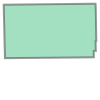

In [21]:
# [index_find]
# br.iloc[0]
dt_agg['renovation']['dataset_hub']['multiPoly'].iloc[1]

# Define plot functions

In [23]:
#@title
def poligono(r, attr, name, colour, linecolor, fill_opacity, opacity, plot): #geometry_newArea
    # poligono esterno
    if plot:
      sim_geo = gpd.GeoSeries(r[attr])
      geo_j = sim_geo.to_json()
      geo_j = folium.features.GeoJson(data = geo_j, style_function = lambda x: {'fillColor': colour, 'color': linecolor, 
                                                                                'fill_opacity': fill_opacity, 'opacity': opacity}, name= name)
      return geo_j
  
def html(dataset_hub, i, area_hub):
  # html = info sul walk;         htmlb = info sul bike (n+10) perchè dovrò concatenare i due dataset_hub
      html = f'''<p><em><u><span style="font-size: 19px; color: rgb(97, 189, 109);">walk</span></u></em></p>
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 50.0000%;"><strong>n&deg;residences</strong><br></td>
                    <td style="width: 50.0000%;"><strong>n&deg;restaurants</strong></td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;">{dataset_hub.N_residences[i]}</td>
                    <td style="width: 50.0000%;">{dataset_hub.N_restaurants[i]}</td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;"><strong>area(m^2)</strong></td>
                    <td style="width: 50.0000%;"><strong>food waste(kg/d)</strong></td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;">{round(dataset_hub[f'{area_hub}'][i], 2)}</td>
                    <td style="width: 50.0000%;">{dataset_hub['Food_waste(kg/d)'][i]}</td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;"><strong>workers<br></td>
                    <td style="width: 50.0000%;"><strong>covering traditional<br></td>
                </tr>
                <tr>  			
                    <td style="width: 50.0000%;">{dataset_hub.Workers[i]}</td>
                    <td style="width: 50.0000%;">{round(dataset_hub.Covering_index_tradF[i]*100, 2)}%</td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;"><strong>covering VF(LI)</strong><br></td>
                    <td style="width: 50.0000%;"><strong>covering VF(HI)</strong></td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;">{round(dataset_hub['Covering_index_VF(LI)'][i]*100, 2)}%</td>
                    <td style="width: 50.0000%;">{round(dataset_hub['Covering_index_VF(HI)'][i]*100, 2)}%</td>
                </tr>
            </tbody>
        </table>
        <p><br></p>     
        <p><span style="font-size: 19px;"><u><em><span style="color: rgb(84, 172, 210);">bike</span></em></u></span></p>                                
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 50.0000%;"><strong>n&deg;residences</strong><br></td>
                    <td style="width: 50.0000%;"><strong>n&deg;restaurants</strong></td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;">{dataset_hub.N_residences[10+i]}</td>
                    <td style="width: 50.0000%;">{dataset_hub.N_restaurants[10+i]}</td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;"><strong>area(m^2)</strong></td>
                    <td style="width: 50.0000%;"><strong>food waste(kg/d)</strong></td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;">{round(dataset_hub[f'{area_hub}'][10+i], 2)}</td>
                    <td style="width: 50.0000%;">{dataset_hub['Food_waste(kg/d)'][10+i]}</td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;"><strong>workers<br></td>
                    <td style="width: 50.0000%;"><strong>covering traditional<br></td>
                </tr>
                <tr>  			
                    <td style="width: 50.0000%;">{dataset_hub.Workers[10+i]}</td>
                    <td style="width: 50.0000%;">{round(dataset_hub.Covering_index_tradF[10+i]*100, 2)}%</td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;"><strong>covering VF(LI)</strong><br></td>
                    <td style="width: 50.0000%;"><strong>covering VF(HI)</strong></td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;">{round(dataset_hub['Covering_index_VF(LI)'][10+i]*100, 2)}%</td>
                    <td style="width: 50.0000%;">{round(dataset_hub['Covering_index_VF(HI)'][10+i]*100, 2)}%</td>
                </tr>
            </tbody>
        </table>
        <p><br></p>'''         
      return html
  
def html2(dataset_acc, i):
  # html = info sul walk;       
      html = f'''<p><em><u><span style="font-size: 19px; color: rgb(97, 189, 109);">walk</span></u></em></p>
        <table style="width: 100%;">
            <tbody>
                <td style="width: 50.0000%;">{dataset_acc.N_hubs_included}%</td>
                <td style="width: 50.0000%;">{round(dataset_acc['Cover_index(T)'][i]*100, 2)}%</td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;"><strong>covering VF(LI)</strong><br></td>
                    <td style="width: 50.0000%;"><strong>covering VF(HI)</strong></td>
                </tr>
                <tr>
                    <td style="width: 50.0000%;">{round(dataset_acc['Cover_index(LI)'][i]*100, 2)}%</td>
                    <td style="width: 50.0000%;">{round(dataset_acc['Cover_index(HI)'][i]*100, 2)}%</td>
                </tr>
            </tbody>
        </table>
        <p><br></p>'''    
      return html


# def multipoligono(r, name, colour, linecolor, fill_opacity, opacity, plot): #geometry_newArea
#   # poligono esterno
#   if plot:
#     multiS = pd.Series(r.multiPoly)
#     multiSG = gpd.GeoSeries.from_wkt(multiS)
#     sim_geo = gpd.GeoSeries(multiSG)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.features.GeoJson(data = geo_j, style_function = lambda x: {'fillColor': colour, 'color': linecolor, 
#                                                                               'fill_opacity': fill_opacity, 'opacity': opacity}, name= name)
#     return geo_j



# Legend function

In [24]:
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Color Legend (draggable!)</div>
<div class='legend-subtitle'>Colours chosen to help colourblinds</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#40B0A6;opacity:0.7;'></span>Milan boundary </li>
    <li><span style='background:#994F00;opacity:0.7;'></span>Bike & Walk accessability</li>
    <li><span style='background:#1AFF1A;opacity:0.7;'></span>Usable Hub area</li>
    <li><span style='background:#4B0092;opacity:0.7;'></span>Hub perimeter</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-subtitle {
    text-align: left;
    margin-bottom: 5px;
    font-weight: italic;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

legend = MacroElement()
legend._template = Template(template)

# Milan plot function

In [25]:
def milano():
  ci = gpd.read_file('/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/Comune_Milano/Copia di Com01012022_WGS84.shp')
  ci = ci.to_crs(4326)
  cm = ci[ci['COMUNE']=='Milano']
  return cm

# Map
*   The Marker must be a green house ([icons](https://getbootstrap.com/docs/3.3/components/))



In [50]:
# Funzioni di plot e info
def plot_and_info(dt_agg, map, save, legend):
  
  for name, dt in dt_agg.items():
    
    if name == 'renovation':
      renovation = True
    else:
      renovation = False

    # mostra solo il primo layer = new building
    if name == list(dt_agg.keys())[0]:
      fg = folium.FeatureGroup(name)
    else:
      fg = folium.FeatureGroup(name, show = False)
    
    # Plot the hub and relative informations
    for i, r in dt['dataset_hub'].iterrows():
      if i < 10:   #walk + info anche su bike
        if not renovation:
          #poli esterno
          pe = poligono(r=r, attr='geometry_newArea', name=name, colour='#00000000', linecolor='#4B0092', fill_opacity = 0.2, opacity=1, 
                        plot = True)
          pe.add_to(fg)
        
          # poligono interno
          pi = poligono(r=r, attr='final_geometry_rectangular', name=name, colour='#1AFF1A', linecolor='#1AFF1A', fill_opacity = 0.7, opacity=1,
                        plot = True)
          pi.add_to(fg)

          iframe = folium.IFrame(html(dt['dataset_hub'], i, area_hub = 'final_area'), 
                                  width=275,
                                  height=200)
          
          popup = folium.Popup(iframe, max_width="100%")
          # Create a list of coordinate pairs
          marker = folium.Marker([r.centroid.y, r.centroid.x],popup=popup, tooltip='Hub info', marker_color='#1AFF1A', 
                                icon = folium.Icon(color = 'green', icon = 'glyphicon-home',  prefix='glyphicon'))
          # marker.add_to(fg)
          fg.add_child(marker)


        if renovation:
          # aggiungi il plot del multipoly
          multip =  poligono(r=r, attr='multiPoly', name=name, colour='#1AFF1A', linecolor='#1AFF1A', fill_opacity = 0.2, opacity=1, 
                        plot = True)
          multip.add_to(fg)
            
          iframe = folium.IFrame(html(dt['dataset_hub'], i, area_hub = 'final_area'), 
                                    width=275,
                                    height=200)
            
          popup = folium.Popup(iframe, max_width="100%")
          # Create a list of coordinate pairs
          marker = folium.Marker([r.centroid.y, r.centroid.x],popup=popup, tooltip='Hub info', marker_color='#1AFF1A', 
                                icon = folium.Icon(color = 'green', icon = 'glyphicon-home',  prefix='glyphicon'))
          fg.add_child(marker)


  # Plot the hub accessability area and relative informations (il primo dataset deve essere walk)

    # walk = folium.plugins.FeatureGroupSubGroup(fg, "Walk", show = True)
    # bike = folium.plugins.FeatureGroupSubGroup(fg, "Bike", show = False)
    
    if not renovation:
      index_used = []
      for i, r in dt['dataset_acc'].iterrows():
        index_used.append(i)
        if i not in index_used:   #caso walk
          # mil = poligono(r=milan, attr='geometry', name='Milan', colour='#00000000', linecolor = '#40B0A6', fill_opacity = 0.2, opacity=1, plot = True)
          # mil.add_to(fg)
          
          # poligono
          w = poligono(r=r, attr='polygon_merged', name=name, colour='#994F00', linecolor='#994F00', fill_opacity = 0.6, opacity=1, plot =True)
          w.add_to(fg)

          iframe = folium.IFrame(html2(dt['dataset_acc'], i), 
                                      width=275,
                                      height=200)
          popup = folium.Popup(iframe, max_width="100%")
          
        if i in index_used:   # caso bike
  
          # mil = poligono(r=milan, attr='geometry', name='Milan', colour='#00000000', linecolor = '#40B0A6', fill_opacity = 0.2, opacity=1, plot = True)
          # mil.add_to(fg)
          
          # poligono
          b = poligono(r=r, attr='polygon_merged', name=name, colour='#994F00', linecolor='#994F00', fill_opacity = 0.2, opacity=1, plot =True)
          b.add_to(fg)



          iframe = folium.IFrame(html2(dt['dataset_acc'], i), 
                                      width=275,
                                      height=200)
            
          popup = folium.Popup(iframe, max_width="100%")
          centroid = r.polygon_merged.centroid
    
    if renovation:
      index_used = []
      for i, r in dt['dataset_acc'].iterrows():
        index_used.append(i)
        if i not in index_used:   #caso walk
          # mil = poligono(r=milan, attr='geometry', name='Milan', colour='#00000000', linecolor = '#40B0A6', fill_opacity = 0.2, opacity=1, plot = True)
          # mil.add_to(fg)
          
          # poligono
          w = poligono(r=r, attr='polygon_merged', name=name, colour='#994F00', linecolor='#994F00', fill_opacity = 0.6, opacity=1, plot = True)
          w.add_to(fg)


          iframe = folium.IFrame(html2(dt['dataset_acc'], i), 
                                      width=275,
                                      height=200)
          popup = folium.Popup(iframe, max_width="100%")
            
        if i in index_used:   # caso bike

          # mil = poligono(r=milan, attr='geometry', name='Milan', colour='#00000000', linecolor = '#40B0A6', fill_opacity = 0.2, opacity=1, plot = True)
          # mil.add_to(fg)

          # poligono
          b = poligono(r=r, attr='polygon_merged', name=name, colour='#994F00', linecolor='#994F00', fill_opacity = 0.2, opacity=1, plot = True)
          b.add_to(fg)


          iframe = folium.IFrame(html2(dt['dataset_acc'], i), 
                                      width=275,
                                      height=200)
            
          popup = folium.Popup(iframe, max_width="100%")
          centroid = r.polygon_merged.centroid
    
    milan = milano()
    mil = poligono(r=milan, attr='geometry', name='Milan', colour='#00000000', linecolor = '#40B0A6', fill_opacity = 0.1, opacity=1, plot = True)
    mil.add_to(fg)
    fg.add_to(map)
    # fgM.add_to(map)


  fgM = folium.FeatureGroup('Milan', show = True, control = True, default = True)
  milan = milano()
  mil = poligono(r=milan, attr='geometry', name='Milan', colour='#00000000', linecolor = '#40B0A6', fill_opacity = 0.1, opacity=1, plot = True)
  mil.add_to(fgM)

  fgM.add_to(map)

  folium.LayerControl().add_to(map)

  map.get_root().add_child(legend)
  
  if save:
    map.save(f"/content/gdrive/MyDrive/Project Lab Smart Cities/Mappe_html/Map_unique.html")

  return map

# Plot map

In [69]:
m = folium.Map([45.4612,9.1595], tiles= "openstreetmap", zoom_start=11, max_zoom=23, control_scale=True)
plot_and_info(dt_agg = dt_agg, map=m, legend = legend, save = True)